# Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

In [3]:
duration = data[duration_col].to_numpy().squeeze()
event = data[event_col].to_numpy().squeeze()

In [4]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [5]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X = feature_scaling(X)

In [6]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients 

In [7]:
N_SPLITS = 3
DATA_SPLIT_IDX = [np.arange(data.shape[0])] * N_SPLITS  #np.array_split(np.arange(data.shape[0]), N_SPLITS)

In [8]:
from utils.client import Client 

participants = [] 

rho = 1

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots, learning_rate=0.001)

    participants.append(client)

2025-05-26 08:29:05.108053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initialize parameters

In [9]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration)

# Initialize beta coefficients
beta = init_beta(X, y)

In [10]:
for client in participants:
    client.set_params({"beta": beta, "gamma": gamma})

# Client fitting

In [11]:
# For convergence
# - Initial global parameters
z_beta = np.zeros_like(client.beta)
z_gamma = np.zeros_like(client.gamma)
# - Smoothing factor 
alpha = 0.5 #0.01
# - Exponential moving average
z_beta_prev = z_beta.copy()
z_gamma_prev = z_gamma.copy()

In [12]:
EPS = 1e-4
N_ITER_GLOBAL = 15000

Iter 0: 0.05130950476849665; 0.7749305959611396
Iter 1500: 8.198564153043501e-05; 0.002645693951979807
Iter 3000: 0.0003867262313354674; 0.0026456699408799115
Iter 4500: 0.0004003878411679964; 0.0026456708814182675
Iter 6000: 0.00013418151792001697; 0.0010894282532867116
Converged after 6293 iterations


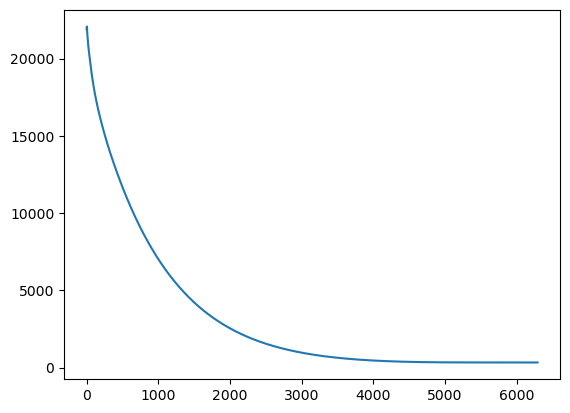

In [13]:
def relative_change(params, params_other):
    return np.linalg.norm(params - params_other) #/ (np.linalg.norm(params) + 1e-12)


def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 


def cosine_annealing_lr(epoch, max_epochs, initial_lr=0.1, min_lr=0.0001):
    """
    Cosine annealing learning rate scheduler.
    """
    cos_inner = np.pi * epoch / max_epochs
    lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(cos_inner))
    return lr
    

losses = []
for i in range(N_ITER_GLOBAL):

    update_beta, update_gamma, last_local_losses = [], [], []
    for client in participants:

        # Fit client 
        client.fit_model_fedadmm(z_beta, z_gamma)
        # Gather update parameters 
        update_beta.append(client.beta + client.u_beta / rho)
        update_gamma.append(client.gamma + client.u_gamma / rho)

        # Trace training loss per client 
        last_local_losses.append(client.loss)

    # Average training loss across clients 
    losses.append(np.mean(last_local_losses))
    
    # Global update
    z_beta = np.mean(update_beta, axis=0)
    z_gamma = np.mean(update_gamma, axis=0)

    # NOTE TEMP 
    alpha = cosine_annealing_lr(i, N_ITER_GLOBAL)

    # Update moving average convergence parameters 
    z_beta = alpha * z_beta + (1 - alpha) * z_beta_prev
    z_gamma = alpha * z_gamma + (1 - alpha) * z_gamma_prev
    
    if has_converged(z_beta_prev, z_beta) and has_converged(z_gamma_prev, z_gamma):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = relative_change(z_beta_prev, z_beta)  
        change_gamma = relative_change(z_gamma_prev, z_gamma)  
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    # Update previous parameter estimate 
    z_beta_prev = z_beta
    z_gamma_prev = z_gamma

    for client in participants:
        # Update duals 
        client.update_duals(z_beta, z_gamma)

plt.figure()
plt.plot(losses)
# PROBLEM: The difference between consecutive parameter estimates seem to be converging. 
# This could mean that consecutive estimates alternate between similar solutions. 

In [14]:
# Save loss data to disk 
np.save("../data/losses/rossi_admmavg.npy", losses)

# Global model 

In [15]:
np.save("../data/params/rossi_admmavg_beta_global.npy", z_beta)
z_beta

array([[-0.18216035, -0.32806282,  0.09758784, -0.07530462, -0.13641084,
        -0.03789759,  0.25612927]])

In [16]:
np.save("../data/params/rossi_admmavg_gamma_global.npy", z_gamma)
z_gamma

array([[-6.26677934, -5.00163398, -3.90597534, -2.0764219 , -1.69278005,
        -1.39375641, -1.25621349]])

# Reference model

Converged after 4426 iterations


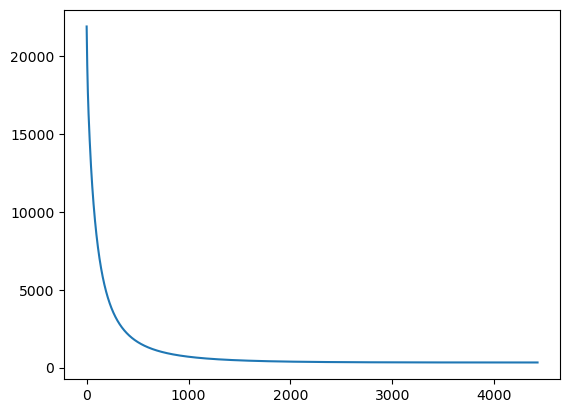

In [17]:
from utils.model import Model

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.01, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [18]:
ref_model.beta

array([[-0.17536245, -0.30535272,  0.09445201, -0.07586177, -0.12871987,
        -0.03621313,  0.24828063]], dtype=float32)

In [19]:
z_beta

array([[-0.18216035, -0.32806282,  0.09758784, -0.07530462, -0.13641084,
        -0.03789759,  0.25612927]])

In [20]:
ref_model.gamma

array([[-6.2007933, -4.9384947, -3.8407304, -2.0178106, -1.6342392,
        -1.3359975, -1.1990117]], dtype=float32)

In [21]:
z_gamma

array([[-6.26677934, -5.00163398, -3.90597534, -2.0764219 , -1.69278005,
        -1.39375641, -1.25621349]])

In [22]:
# Training until 5K epochs: 0.06939954423736899
relative_change(z_beta, ref_model.beta)

0.026376005635351456

In [23]:
# Training until 5K epochs: 0.11927933753618518
relative_change(z_gamma, ref_model.gamma)

0.16145616100893

# Number of clients 

Iter 0: 0.05131478193028471; 0.7749305959611269
Iter 1500: 0.00014428822941598608; 0.0026456640236625765
Iter 3000: 8.85463095238161e-05; 0.0023512518433471347
Iter 4500: 0.00019770288747880622; 0.002467833863191925
Converged after 5309 iterations
Converged after 4426 iterations


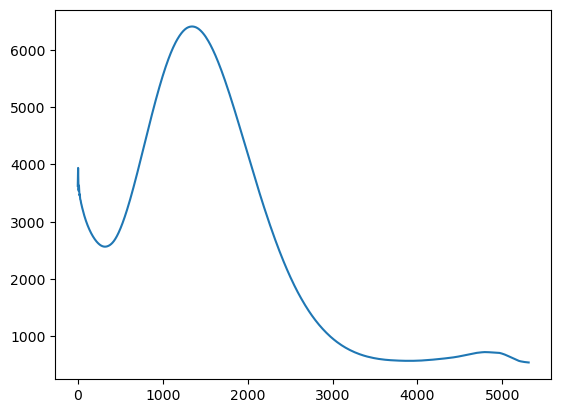

In [29]:
from utils.splines import bspline_design_matrix
from utils.data import init_gamma, init_beta
from utils.client import Client 
from utils.model import Model

rho = 1
beta = init_beta(X, y)
gamma = init_gamma(bspline_design_matrix(np.log(duration), knots), duration)

N_SPLITS = 6
DATA_SPLIT_IDX = np.array_split(np.arange(data.shape[0]), N_SPLITS)

participants = [] 
for idx in DATA_SPLIT_IDX:
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    client.preprocess_data(train_test_split=False)
    client.init_model(local_knots=False, knots=knots, learning_rate=0.001)
    client.set_params({"beta": beta, "gamma": gamma})

    participants.append(client)

z_beta = np.zeros_like(client.beta)
z_gamma = np.zeros_like(client.gamma)
z_beta_prev = z_beta.copy()
z_gamma_prev = z_gamma.copy()

alpha = 0.5 
EPS = 1e-4
N_ITER_GLOBAL = 15000
    

losses = []
for i in range(N_ITER_GLOBAL):

    update_beta, update_gamma, last_local_losses = [], [], []
    for client in participants:

        # Fit client 
        client.fit_model_fedadmm(z_beta, z_gamma)
        # Gather update parameters 
        update_beta.append(client.beta + client.u_beta / rho)
        update_gamma.append(client.gamma + client.u_gamma / rho)

        # Trace training loss per client 
        last_local_losses.append(client.loss)

    # Average training loss across clients 
    losses.append(np.mean(last_local_losses))
    
    # Global update
    z_beta = np.mean(update_beta, axis=0)
    z_gamma = np.mean(update_gamma, axis=0)

    # NOTE TEMP 
    alpha = cosine_annealing_lr(i, N_ITER_GLOBAL)

    # Update moving average convergence parameters 
    z_beta = alpha * z_beta + (1 - alpha) * z_beta_prev
    z_gamma = alpha * z_gamma + (1 - alpha) * z_gamma_prev
    
    if has_converged(z_beta_prev, z_beta) and has_converged(z_gamma_prev, z_gamma):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = relative_change(z_beta_prev, z_beta)  
        change_gamma = relative_change(z_gamma_prev, z_gamma)  
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    # Update previous parameter estimate 
    z_beta_prev = z_beta
    z_gamma_prev = z_gamma

    for client in participants:
        # Update duals 
        client.update_duals(z_beta, z_gamma)

plt.figure()
plt.plot(losses)

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.01, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

version = f"{N_SPLITS}_clients"

np.save(f"../data/params/rossi_admmavg_beta_global_{version}.npy", z_beta)
np.save(f"../data/params/rossi_admmavg_gamma_global_{version}.npy", z_gamma)
np.save(f"../data/params/rossi_admmavg_beta_global_ref_{version}.npy", ref_model.beta)
np.save(f"../data/params/rossi_admmavg_gamma_global_ref_{version}.npy", ref_model.gamma)